# Naive RAG vs ReAct Agent

- **GitHub: https://github.com/albertgilopez**
- **LinkedIn: Albert Gil López: https://www.linkedin.com/in/albertgilopez/**
- **Inteligencia Artificial Generativa (IAG) en español: https://www.codigollm.es/**


Los prototipos basados en la aproximación RAG (Retrieval Augmented Generation) son limitados en la práctica. Esta aproximación *Naive* del RAG tienda a funcionar bien para preguntas sencillas entorno a un conjunto pequeño de datos o documentos. Pero, ¿qué pasa cuando...?


* “What are the main risk factors for Tesla?” (over Tesla 2021 10K)
* “What did the author do during his time at YC?” (Paul Graham essay)

Hay una serie de preguntas que no podemos resolver con esta aproximación, por ejemplo:

* **Preguntas de resumen**: “Dame un resumen de toda la <empresa>. Informe anual 10K”
* **Preguntas comparativas**: “Compara las contribuciones de código abierto del
candidato A y el candidato B”
* **Análisis estructurado** + búsqueda semántica: “Cuéntame sobre los factores de riesgo de la empresa de viajes compartidos de mayor rendimiento en EE.UU.”
* **Preguntas generales de varias partes**: "Cuéntame sobre los argumentos a favor de X en el artículo A, y cuéntame sobre los argumentos a favor de Y en el artículo B, haz una tabla basada en nuestra guía de estilo interna, luego genera tu propia conclusión basada en estos hechos."

**Entonces, ¿podemos llegar a hacer más?**

El caso es que la aproximación *Naive* del RAG es aburrida:

* Es sólo un sistema de búsqueda glorificado 🚫

* Hay muchas preguntas/tareas a las que el *Naive RAG* no puede dar respuesta 🚫


*💡 ¿Podemos ir más allá de la simple búsqueda/QA para crear un asistente de investigación que tenga un contexto aumentado?*

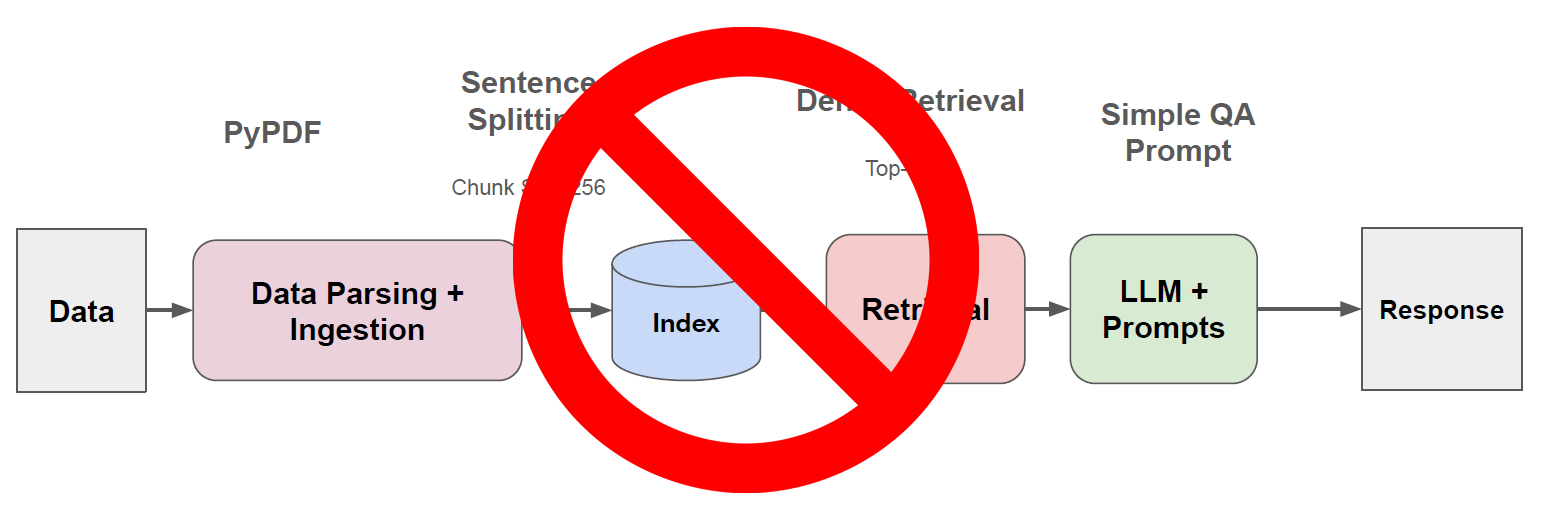

El flujo que hasta ahora estábamos utilizando era el siguiente:

1. **Entrada de Datos**: El proceso comienza con una entrada de datos brutos. Estos datos pueden ser de cualquier tipo, como documentos de texto, PDFs, etc.
2. **Análisis y Ingesta de Datos**. Por ejemplo, mediante el uso de PyPDF, o cualquier otra librería para extraer y procesar el texto de los documentos, el texto extraído se divide en *chunks* o segmentos más pequeños de un tamaño específico.
3. **Indexación**: Los segmentos de datos procesados se indexan en una base de datos vectorizada o sistema de indexación para facilitar la recuperación rápida de la información relevante.
4. **Recuperación o Retrieval**: Se realiza una búsqueda en la base de datos indexada para encontrar las cinco mejores coincidencias *(Top-k = 5)* que respondan a una consulta específica. Esto se conoce como recuperación o *retrieval*, y es lo que utilizan los LLM para entender y recuperar los fragmentos más relevantes del texto.
5. **LLM + Prompts**: En esta etapa, las cinco mejores coincidencias seleccionadas se pasan al LLM, que genera respuestas basadas en los prompts o consultas proporcionadas. Este modelo utiliza los fragmentos recuperados para construir y contextualizar la respuesta.
6. **Respuesta**: Finalmente, el modelo de lenguaje produce una respuesta basada en la información recuperada y procesada, completando así el flujo de trabajo de consulta y respuesta.

## Loading Data (ingest)

Antes de que el LLM pueda actuar sobre los datos, primero debemos procesar los datos y cargarlos. Esto tiene un paralelismo con las tuberías de datos/ingeniería de funciones en el mundo ML, o el concepto ETL en la configuración de datos tradicional.

Esta fase consta normalmente de 3 etapas:

1. Cargar los datos
2. Transformar los datos
3. Indexa y almacena los datos

**Loaders**

LlamaIndex (https://www.llamaindex.ai/) es un Data Framework para desarrollar aplicaciones LLM.

La forma en que lo hace LlamaIndex es mediante conectores de datos, también llamados *Reader*. Los conectores de datos ingieren datos de diferentes fuentes de datos y dan formato a los datos en objetos *Document*. Un documento es una colección de datos (actualmente texto, y en el futuro, imágenes y audio) y metadatos sobre estos datos.

La manera más sencilla es utilizar *SimpleDirectoryReader*, que crea documentos a partir de cada archivo de un directorio determinado. Está integrado en LlamaIndex y puede leer una variedad de formatos como Markdown, PDF, documentos de Word, decks de PowerPoint, imágenes, audio y vídeo.

In [28]:
# https://pypi.org/project/llama-index/
# !pip install llama-index

from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader("./data").load_data()

In [29]:
documents

[Document(id_='74bf99e3-c31c-409f-9b76-4a1ac8975611', embedding=None, metadata={'page_label': '1', 'file_name': 'startup-crecimiento-paul-graham.pdf', 'file_path': '/content/data/startup-crecimiento-paul-graham.pdf', 'file_type': 'application/pdf', 'file_size': 182411, 'creation_date': '2024-05-05', 'last_modified_date': '2024-05-05'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text=' \nENSA YOS\nLIBROS\nNOTICIAS\nYC\nLISP\nFAQs\nRAQs\nCITAS\nBIOGRAFÍA\nBUSCAR\nSTARTUP  = CRECIMIENT O\nSeptiembre de 2012\nUna startup es una empresa diseñada para crecer rápido. Ser recién fundada no hace en sí a una startup.\nTampoco es necesario que una startup trabaje en tecnología, o que acepte financiamiento de riesgo, o tenga\nalgún tipo de "salida". Lo único esencial

## Transformations

Después de cargar los datos, deben procesarse y transformarse antes de ponerlos en un sistema de almacenamiento. Estas transformaciones incluyen fragmentar, extraer metadatos o hacer *embeddings* de todo. Esto es necesario para asegurarse de que los datos se pueden recuperar y utilizar de forma óptima para el LLM.

Las entradas/salidas de esta transformación son objetos *Node* (un Documento* es una subclase de un Node*).

LlamaIndex cuenta con una API de alto nivel y otra aproxiamción más bajo nivel para transformar documentos. Los índices tienen un método *.from_documents()* que acepta una matriz de objetos *Document* y los analiza y fragmenta correctamente. Sin embargo, a veces querrás un mayor control sobre cómo se dividen los documentos.

In [30]:
import nest_asyncio

nest_asyncio.apply()

from llama_index.core.extractors import (
    TitleExtractor,
    QuestionsAnsweredExtractor,
)

from llama_index.core.node_parser import TokenTextSplitter

text_splitter = TokenTextSplitter(
    separator=" ", chunk_size=512, chunk_overlap=128
)
title_extractor = TitleExtractor(nodes=1)
qa_extractor = QuestionsAnsweredExtractor(questions=3)

from llama_index.core.ingestion import IngestionPipeline

pipeline = IngestionPipeline(
    transformations=[text_splitter, title_extractor, qa_extractor]
)

nodes = pipeline.run(
    documents=documents,
    in_place=True,
    show_progress=True,
)

nodes

Parsing nodes:   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 27/27 [00:10<00:00,  2.55it/s]


[TextNode(id_='f3ab3e8e-27ef-499f-b3bf-a85f13a35acd', embedding=None, metadata={'page_label': '1', 'file_name': 'startup-crecimiento-paul-graham.pdf', 'file_path': '/content/data/startup-crecimiento-paul-graham.pdf', 'file_type': 'application/pdf', 'file_size': 182411, 'creation_date': '2024-05-05', 'last_modified_date': '2024-05-05', 'document_title': '"Startup: Diseñadas para Crecer Rápido - Estrategias y Consejos para el Éxito Empresarial"', 'questions_this_excerpt_can_answer': '1. What is the essential characteristic of a startup according to Paul Graham?\n2. How does Paul Graham distinguish startups from other newly founded businesses?\n3. Why does Paul Graham compare startups to sequoia seeds and soybean sprouts in terms of growth potential and nature?'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modifie

## Indexing

Con los datos cargados, ahora tenemos una lista de objetos de documento (o una lista de nodos). Es hora de crear un índice sobre estos objetos para que podamos empezar a consultarlos.

**Ahora, ¿qué es un índice?** En términos de LlamaIndex, un índice es una estructura de datos compuesta por objetos *Document*, diseñada para permitir la consulta por parte de un LLM. El índice está diseñado para ser complementario a la estrategia de consulta.

LlamaIndex ofrece varios tipos de índices distintos.

**VectorStoreIndex**
Un *VectorStoreIndex* es, con diferencia, el tipo de índice más frecuente que se encuentra. Este índice toma los documentos y los divide en nodos. A continuación, crea *embeddings* vectoriales del texto de cada nodo, listo para ser consultado por un LLM.

**¿Qué es un embedding?**
Los vector *embeddings* son fundamentales para el funcionamiento de las aplicaciones LLM.

Un embedding es una representación numérica de la semántica o significado del texto. Dos fragmentos de texto con significados similares tendrán *embeddings* matemáticamente similares, aunque el texto real sea bastante diferente.

Esta relación matemática permite la búsqueda semántica, donde un usuario proporciona términos de consulta y LlamaIndex puede localizar el texto relacionado con el significado de los términos de la consulta en lugar de una simple concordancia de palabras clave. Ésta es una gran parte del funcionamiento de la generación aumentada con la recuperación y de cómo funcionan los LLM en general.

Hay muchos tipos de *embeddings*, y varían en eficiencia, efectividad y coste computacional. Por defecto, LlamaIndex utiliza **text-embedding-ada-002**, que es el *embedding* predeterminado que utiliza OpenAI. Puedes utilizar diferentes modelos dependiendo del LLM que se quiera utilizar.

**Vector Store Index** convierte todo el texto en *embeddings* mediante una API de su LLM. Si se debe procesar mucho texto, generar *embeddings* puede tardar mucho tiempo, ya que implica muchas llamadas de API de ida y vuelta.

Cuando se quiere buscar en los *embeddings*, la consulta también se convierte en un embedding y, a continuación, VectorStoreIndex hace una operación matemática para clasificar todos los embedding según el parecido semántico que están en la consulta.

**Top K Retrieval**

Una vez completada la clasificación, VectorStoreIndex devuelve los embedding más parecidos como fragmentos de texto correspondientes. El número de *embeddings* que devuelve se conoce como **k**, por lo que el parámetro que controla cuántos *embeddings* se devuelve se conoce como **top_k**. Todo este tipo de búsqueda se llama a menudo "**recuperación semántica top-k**" por este motivo.

La recuperación Top-k* es la forma más sencilla de consultar un índice vectorial;

In [31]:
# !pip install python-dotenv

from dotenv import load_dotenv
from openai import OpenAI

# Cargamos las variables de entorno desde el archivo .env
load_dotenv()

from llama_index.core import VectorStoreIndex

index = VectorStoreIndex(nodes)

## Querying

Ahora ya hemos cargado los datos, hemos creado un índice y lo hemos almacenado para más adelante, ya podemos acceder a la parte más importante de una aplicación LLM: consultar.

En su forma más sencilla, la consulta es sólo una llamada rápida a un LLM: puede ser una pregunta y obtener una respuesta, o una solicitud de resumen, o una instrucción mucho más compleja.

Las consultas más complejas podrían implicar solicitudes repetidas/encadenadas + llamadas LLM, o incluso un bucle de razonamiento entre varios componentes (agentes)

In [32]:
query_engine = index.as_query_engine()
response = query_engine.query(
    "Haz un resumen del articulo y haz una lista de los 5 aprenzidajes extraídos del texto"
)
print(response)

El artículo aborda la importancia de buscar ideas de rápido crecimiento y un mercado amplio al iniciar una startup. Se discute cómo las startups exitosas no están limitadas por el tamaño de los mercados a los que sirven, ya que podrían expandirse a nuevos mercados. También se menciona que las restricciones en un negocio normal protegen contra la competencia pero también dificultan la generación de nuevas ideas.

Los 5 aprendizajes extraídos del texto son:
1. Es crucial para las startups entender todas las implicaciones de sus descubrimientos intuitivos.
2. No todas las startups se limitan a abordar problemas técnicos difíciles; hay diversas formas de emprender.
3. Las empresas exitosas no están limitadas por el tamaño de los mercados, ya que pueden expandirse a nuevos mercados.
4. Las restricciones en un negocio normal protegen contra la competencia pero también dificultan la generación de nuevas ideas.
5. La segmentación de la organización puede ser una forma de superar los límites in

Aunque el proceso de consulta es más complejo, *Querying* consiste en diferentes fases:

- **Retrieval**. La recuperación es cuando encontramos y devolvemos los documentos más relevantes para la consulta utilizando nuestro índice. Como se ha comentado anteriormente en la indexación, el tipo más común de recuperación es la recuperación semántica *"Top-k"*, pero existen muchas otras estrategias de recuperación.

- El **postprocesamiento** es cuando los nodos recuperados se vuelven a clasificar, transforman o filtran, por ejemplo, requiriendo que tengan metadatos específicos, como palabras clave adjuntas.

- La **síntesis de la respuesta** es cuando la consulta, los datos más relevantes y la solicitud se combinan y envían al LLM para devolver una respuesta.

In [33]:
from llama_index.core import VectorStoreIndex, get_response_synthesizer
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor

# Se configura la manera en que queremos recuperar la información
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=5,
)

# Como queremos que el LLM nos de la respuesta
response_synthesizer = get_response_synthesizer()

# Juntamos todas las piezas en un query_engine
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.7)],
)

response = query_engine.query("Haz un resumen del articulo y haz una lista de los 5 aprenzidajes extraídos del texto")
print(response)

El artículo aborda la importancia de buscar ideas de rápido crecimiento y un mercado amplio al iniciar una startup, comparando las limitaciones y oportunidades entre startups y negocios ordinarios. Se discute cómo las restricciones en los negocios tradicionales protegen pero también limitan la generación de nuevas ideas, mientras que en las startups, los fundadores exitosos identifican problemas pasados por alto y crean empresas exitosas en un entorno tecnológico cambiante. Se destaca la optimización del crecimiento semanal en startups y cómo la presión por mantener una tasa de crecimiento constante puede llevar al descubrimiento de nuevas ideas y oportunidades. Además, se menciona cómo las startups exitosas evitan la decepción, se centran en satisfacer las necesidades de los usuarios y mantienen el crecimiento sostenido. En cuanto a los aprendizajes extraídos del texto, se pueden resumir en:
1. La importancia de buscar ideas innovadoras y novedosas en el mundo de las startups.
2. La n

## Evaluating

Evaluación y benchmarking son crucial. Para conocer la *performance* de la aplicación de LLM (RAG, agentes) tienes que tener una manera de medirlo.

LlamaIndex ofrece módulos clave para medir la calidad de los resultados generados. También ofrecemos módulos clave para medir la calidad de la información recuperada.

¿Y que tenemos en cuenta?

* **¿La respuesta coincide con el contexto recuperado? ¿También coincide con la consulta?**
* **¿Coincide con la respuesta de referencia o con las pautas?**

In [34]:
from llama_index.core.evaluation import FaithfulnessEvaluator

# Aquí se define el tipo de evaluador
evaluator = FaithfulnessEvaluator()

response = query_engine.query(
    "¿Cómo suelen trabajar las startups que triunfan?"
)
eval_result = evaluator.evaluate_response(response=response)
print(str(eval_result.passing))

True


In [35]:
from llama_index.core.evaluation import RetrieverEvaluator

retriever_evaluator = RetrieverEvaluator.from_metric_names(
      ["mrr", "hit_rate"], retriever=retriever
)

retriever_evaluator.evaluate(
    query="¿En qué se diferencian los fundadores de startups exitosos como los de Google en su enfoque para enriquecerse a través de sus empresas en comparación con los fundadores de startups que luchan?",
    expected_ids=["a7dcddfa-5c9e-45f8-82c5-33fb2289900e"]
)

RetrievalEvalResult(query='¿En qué se diferencian los fundadores de startups exitosos como los de Google en su enfoque para enriquecerse a través de sus empresas en comparación con los fundadores de startups que luchan?', expected_ids=['a7dcddfa-5c9e-45f8-82c5-33fb2289900e'], expected_texts=None, retrieved_ids=['7d0ae3ba-72ea-4cfa-b010-cb6d0fe8294a', '201c6556-c548-44e5-9e1e-7f27b7e07e5e', 'f79b0b5c-3773-4dd4-9424-66918aeacbd0', 'd83de6a9-cfd3-4673-96e6-30d7e5d5eb5b', '9132fee0-e531-4b4b-960e-8d6cd0e584db'], retrieved_texts=['Casi todas las empresas necesitan una cierta cantidad de fondos para empezar . Pero a menudo las startups\nrecaudan dinero incluso cuando son o pueden ser rentables. Puede parecer tonto vender acciones de una\nempresa rentable por menos de lo que piensas que más adelante valdrán, pero no es más tonto que comprar\nun seguro. En esencia es la manera como las startups más exitosas ven la recaudación de fondos. Podrían\ncrecer la compañía con sus propios ingresos, per

## RAG Avanzado
Crear un prototipo de una aplicación RAG es fácil, pero lograr que sea eficaz, robusta y escalable a un gran dataset de información es difícil.

Vamos a ver algunos ejemplos de cómo optimizar el rendimiento de la recuperación y la generación para responder más consultas sobre conjuntos de datos más complejos con precisión y sin alucinaciones.

Estas son algunas de las principales consideraciones para la construcción de RAGs más avanzados, pensando sobretodo en cómo llevar estas aplicaciones a producción:

* **Decoupling chunks used for retrieval vs. chunks used for synthesis**
* **Structured Retrieval for Larger Document Sets**
* **Dynamically Retrieve Chunks Depending on your Task**
* **Optimize context embeddings**

### Decoupling Chunks Used for Retrieval vs. Chunks Used for Synthesis

Una técnica clave para una mejor recuperación es desacoplar los chunks utilizados para la recuperación de los que se utilizan para la síntesis.

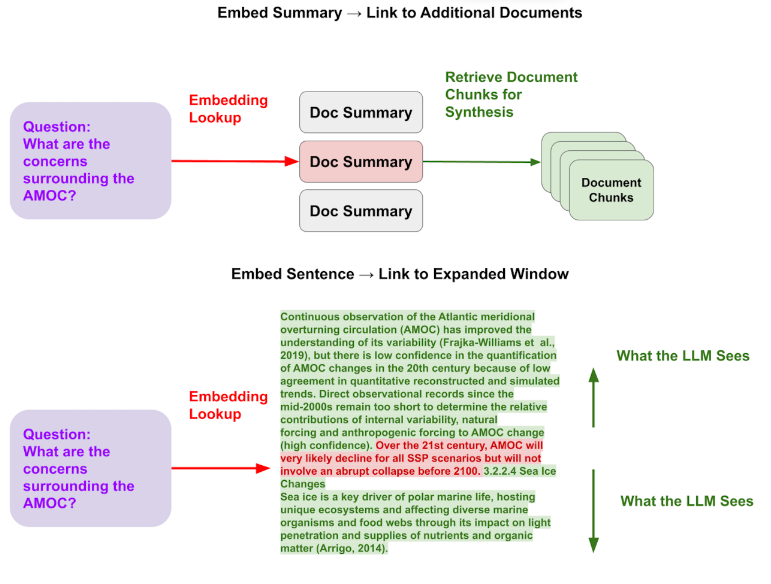


La representación de chunks óptima para la recuperación puede ser diferente de la consideración óptima utilizada para la síntesis. Por ejemplo, un fragmento de texto sin formato puede contener detalles necesarios para que el LLM sintetice una respuesta más detallada a una consulta. Sin embargo, puede contener palabras de relleno/información que pueden sesgar la respuesta, o puede carecer de contexto global y no recuperarse en absoluto cuando llega una consulta relevante.

Hay dos formas principales de aprovechar esta idea:

**1. Embed a document summary, which links to chunks associated with the document.**

Esto puede ayudar a recuperar documentos relevantes antes de recuperar fragmentos directamente (que podrían estar en documentos irrelevantes).

Dos maneras:

* **Table Recursive Retrieval**
* **Document Summary Index**


**Document Summary Index**

https://docs.llamaindex.ai/en/stable/examples/index_structs/doc_summary/DocSummary/

El índice de resumen de documentos extraerá un resumen de cada documento y almacenará ese resumen, así como de todos los nodos correspondientes al documento.

La recuperación se puede realizar a través del LLM o *embeddings*. Primero seleccionamos los documentos relevantes para la consulta en función de sus resúmenes. Se recuperan todos los nodos recuperados correspondientes a los documentos seleccionados.

In [36]:
import nest_asyncio

nest_asyncio.apply()

from llama_index.core import SimpleDirectoryReader, get_response_synthesizer
from llama_index.core import DocumentSummaryIndex
from llama_index.llms.openai import OpenAI
from llama_index.core.node_parser import SentenceSplitter

# LLM (gpt-3.5-turbo)
splitter = SentenceSplitter(chunk_size=1024)

# default mode of building the index
response_synthesizer = get_response_synthesizer(
    response_mode="tree_summarize", use_async=True
)
doc_summary_index = DocumentSummaryIndex.from_documents(
    documents,
    transformations=[splitter],
    response_synthesizer=response_synthesizer,
    show_progress=True,
)

Parsing nodes:   0%|          | 0/10 [00:00<?, ?it/s]

Summarizing documents:   0%|          | 0/10 [00:00<?, ?it/s]

current doc id: 74bf99e3-c31c-409f-9b76-4a1ac8975611
current doc id: 206770b9-6779-4217-99a0-3f281823586a
current doc id: d722650f-9dfc-48a3-8863-ee1125f9fe19
current doc id: 216e58fc-b600-49eb-8fc6-6469775be742
current doc id: ef641721-9978-44d3-ae3b-62c0b4c89438
current doc id: d1932c08-cb07-4c92-8860-94f022b6b080
current doc id: dec63bdd-79d8-43a8-8bd2-1035c07b4f6d
current doc id: 261313a3-c7cf-4ca2-a5dd-ad56496b75a0
current doc id: 2338e0cc-2001-4f94-8f80-87b64cd5846f
current doc id: c8c19f78-7d19-486e-8835-070ed3a7084c


Generating embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

In [37]:
doc_summary_index.get_document_summary("74bf99e3-c31c-409f-9b76-4a1ac8975611")

'The provided text discusses the concept of startups and their fundamental characteristic of rapid growth. It emphasizes that startups are specifically designed to grow quickly and that this growth is the defining feature of such companies. The text also distinguishes startups from other types of businesses, highlighting that not all newly founded companies qualify as startups. It explains that startups are unique in their DNA and purpose, aiming for rapid expansion by offering products or services to a large market.\n\nSome questions that this text can answer include:\n- What defines a startup and sets it apart from other types of businesses?\n- Why is rapid growth essential for startups?\n- How does the concept of scalability differentiate startups from traditional businesses?\n- What role does market demand play in the growth of a startup?\n- Why is understanding the focus on growth crucial for those looking to start a startup?'

In [39]:
response = query_engine.query("¿Qué papel juega la demanda del mercado en el crecimiento de una startup?")
print(response)

La demanda del mercado es fundamental en el crecimiento de una startup, ya que la capacidad de la startup para satisfacer las necesidades y deseos del mercado determina su potencial de crecimiento. Al comprender y responder de manera efectiva a la demanda del mercado, una startup puede ajustar sus estrategias, productos o servicios para captar la atención de los clientes y expandirse con éxito.


In [41]:
# LLM-based Retrieval

from llama_index.core.indices.document_summary import (
    DocumentSummaryIndexLLMRetriever,
)
retriever = DocumentSummaryIndexLLMRetriever(
    doc_summary_index,
    # choice_select_prompt=None,
    # choice_batch_size=10,
    # choice_top_k=1,
    # format_node_batch_fn=None,
    # parse_choice_select_answer_fn=None,
)

retrieved_nodes = retriever.retrieve("¿Qué papel juega la demanda del mercado en el crecimiento de una startup?")

print(len(retrieved_nodes))
print(retrieved_nodes[0].score)
print(retrieved_nodes[0].node.get_text())

1
9.0
ENSA YOS
LIBROS
NOTICIAS
YC
LISP
FAQs
RAQs
CITAS
BIOGRAFÍA
BUSCAR
STARTUP  = CRECIMIENT O
Septiembre de 2012
Una startup es una empresa diseñada para crecer rápido. Ser recién fundada no hace en sí a una startup.
Tampoco es necesario que una startup trabaje en tecnología, o que acepte financiamiento de riesgo, o tenga
algún tipo de "salida". Lo único esencial es el crecimiento. Todo lo demás que asociamos con las startups se
deriva del crecimiento.
Si deseas iniciar una es importante entender eso. Las startups son tan difíciles que no se te puede enviar en la
dirección equivocada y esperar que tengas éxito. Necesitas saber que lo qué estas buscando es el crecimiento.
La buena noticia es que si consigues el crecimiento, todo lo demás tiende a caer en su lugar . Lo que significa
que puedes utilizar el crecimiento como una brújula para tomar casi todas las decisiones que enfrentes.
Secuoyas
Empecemos con una distinción que debería ser obvia pero a menudo se pasa por alto: no todas l

In [42]:
# Usar un retriever como parte de un query engine
from llama_index.core.query_engine import RetrieverQueryEngine

response_synthesizer = get_response_synthesizer(response_mode="tree_summarize")

query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
)

response = query_engine.query("¿Qué papel juega la demanda del mercado en el crecimiento de una startup?")
print(response)

La demanda del mercado juega un papel fundamental en el crecimiento de una startup. Para crecer rápidamente, una empresa debe ofrecer algo que sea deseado por una gran cantidad de personas. Es esencial que la startup pueda llegar y satisfacer las necesidades de ese mercado amplio. Este enfoque en satisfacer la demanda del mercado es crucial para el crecimiento exitoso de una startup, ya que permite escalar el negocio y llegar a una base de clientes más amplia.


**2. Embed a sentence, which then links to a window around the sentence**


Esto permite una recuperación más detallada del contexto relevante (la incorporación de embeddings muy grandes conduce a problemas de "perdida en el medio"), aunque también garantiza suficiente contexto para la síntesis de LLM.


Se puede utilizar esta técnica: **Metadata Replacement Postprocessor**

**Metadata Replacement + Node Sentence Window**

https://docs.llamaindex.ai/en/stable/examples/node_postprocessor/MetadataReplacementDemo/

En este ejemplo, utilizaremos *SentenceWindowNodeParser* para analizar documentos en oraciones simples por nodo. Cada nodo también contiene una "ventana" con las oraciones a cada lado de la oración del nodo.

Luego, durante la recuperación, antes de pasar las oraciones recuperadas al LLM, las oraciones individuales se reemplazan con una ventana que contiene las oraciones circundantes usando *MetadataReplacementNodePostProcessor*.

Esto es más útil para documentos/índices grandes, ya que ayuda a recuperar más detalles. De forma predeterminada, la ventana de oración tiene 5 oraciones a cada lado de la oración original.


In [45]:
from llama_index.core.node_parser import SentenceWindowNodeParser
from llama_index.core.node_parser import SentenceSplitter

# create the sentence window node parser w/ default settings
node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=3,
    window_metadata_key="window",
    original_text_metadata_key="original_text",
)

# base node parser is a sentence splitter
text_splitter = SentenceSplitter()

nodes = node_parser.get_nodes_from_documents(documents)
base_nodes = text_splitter.get_nodes_from_documents(documents)

base_nodes

[TextNode(id_='46f18677-3acc-4d05-9433-1d4891798103', embedding=None, metadata={'page_label': '1', 'file_name': 'startup-crecimiento-paul-graham.pdf', 'file_path': '/content/data/startup-crecimiento-paul-graham.pdf', 'file_type': 'application/pdf', 'file_size': 182411, 'creation_date': '2024-05-05', 'last_modified_date': '2024-05-05'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='74bf99e3-c31c-409f-9b76-4a1ac8975611', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '1', 'file_name': 'startup-crecimiento-paul-graham.pdf', 'file_path': '/content/data/startup-crecimiento-paul-graham.pdf', 'file_type': 'application/pdf', 'file_size': 182411, 'creation_date': '2024-05-05', 'last_modified_date': 

In [46]:
sentence_index = VectorStoreIndex(nodes)
base_index = VectorStoreIndex(base_nodes)

In [47]:
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

query_engine = sentence_index.as_query_engine(
    similarity_top_k=2,
    # the target key defaults to `window` to match the node_parser's default
    node_postprocessors=[
        MetadataReplacementPostProcessor(target_metadata_key="window")
    ],
)
window_response = query_engine.query(
    "¿En qué se diferencian los fundadores de startups exitosos como los de Google en su enfoque para enriquecerse a través de sus empresas en comparación con los fundadores de startups que luchan?"
)
print(window_response)

Los fundadores de startups exitosos como los de Google se diferencian de los fundadores de startups que luchan en su enfoque para enriquecerse a través de sus empresas al ser capaces de identificar problemas diferentes y encontrar soluciones innovadoras para ellos. Además, estos fundadores exitosos suelen tener una visión única y la habilidad de ver oportunidades donde otros no las ven, lo que les permite desarrollar ideas que se vuelven obvias solo después de que ellos las han descubierto.


In [48]:
window = window_response.source_nodes[0].node.metadata["window"]
sentence = window_response.source_nodes[0].node.metadata["original_text"]

print(f"Window: {window}")
print("------------------")
print(f"Original Sentence: {sentence}")

Window: Ese espacio de ideas ha sido tan profusamente explotado que una startup por lo general tiene que trabajar en
algo que todo el mundo ha pasado por alto.  Iba a decir que uno tiene que hacer un esfuerzo consciente para
encontrar ideas que todo el mundo ha pasado por alto.  Pero no es así como empiezan la mayoría de las
startups.  Por lo general las startups exitosas nacen porque los fundadores son tan diferentes a otras personas
que ideas que los demás no pueden ver a ellos les parecen obvias.  Tal vez más tarde dan un paso atrás y notan
que han encontrado una idea en el punto ciego de todos los demás, y desde ese punto hacen un esfuerzo
deliberado por quedarse allí.  [3] Sin embar go, cuando las startups exitosas empiezan, gran parte de la
innovación es inconsciente.
 Lo que diferencia a los fundadores exitosos es que pueden ver diferentes problemas. 
------------------
Original Sentence: Por lo general las startups exitosas nacen porque los fundadores son tan diferentes a otras

In [49]:
# Si lo comparamos con un VectorStoreIndex normal
query_engine = base_index.as_query_engine(similarity_top_k=2)
vector_response = query_engine.query(
    "¿En qué se diferencian los fundadores de startups exitosos como los de Google en su enfoque para enriquecerse a través de sus empresas en comparación con los fundadores de startups que luchan?"
)
print(vector_response)

Los fundadores de startups exitosos, como los de Google, no encuentran beneficios en enriquecerse a costa de la empresa vendiéndole componentes a sobreprecio, ya que para ellos no sería una estrategia que valga la pena. Por otro lado, los fundadores de startups que luchan podrían estar tentados a realizar este tipo de acciones, pero generalmente son descartados desde la perspectiva del capitalista de riesgo.


In [50]:
query_engine = base_index.as_query_engine(similarity_top_k=5)
vector_response = query_engine.query(
    "¿En qué se diferencian los fundadores de startups exitosos como los de Google en su enfoque para enriquecerse a través de sus empresas en comparación con los fundadores de startups que luchan?"
)
print(vector_response)

Los fundadores de startups exitosos, como los de Google, se diferencian de los fundadores de startups que luchan en su enfoque para enriquecerse a través de sus empresas al no recurrir a prácticas cuestionables, como vender componentes a sobreprecio a sus propias empresas. En contraste, los fundadores de startups en problemas podrían verse tentados a recurrir a tales acciones, pero generalmente son descartados por los inversores de riesgo.


### Structured Retrieval for Larger Document Sets

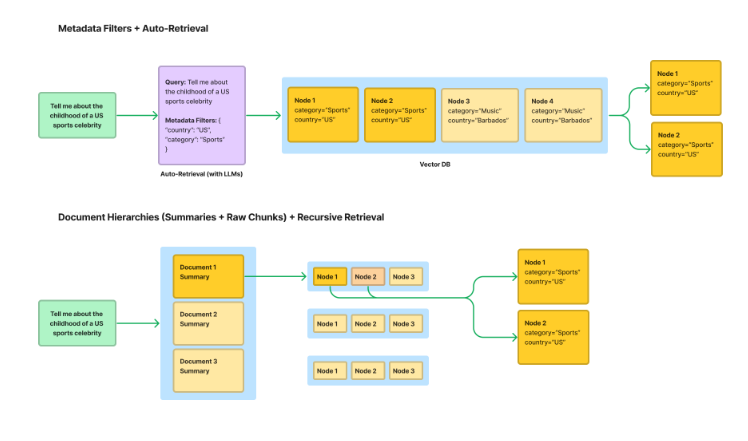

Un gran problema con el RAG estándar (recuperación top-k + división de texto básica) es que no funciona bien a medida que aumenta la cantidad de documentos, por ejemplo, si tienes 100 archivos PDF diferentes. En esta configuración, ante una consulta, es posible que quieras  utilizar información estructurada para ayudar con una recuperación de información más precisa; por ejemplo, si haces una pregunta que solo es relevante para dos archivos PDF, utilizar información estructurada nos garantiza que obtendremos solo los archivos PDF relevantes.

Hay algunas técnicas para realizar un etiquetado/recuperación más estructurado, cada una con sus propias ventajas y desventajas:

1. **Metadata Filters + Auto Retrieval**. Etiqueta cada documento con metadatos y luego guárdalo en una base de datos vectorial. Durante el tiempo de inferencia, utiliza el LLM para inferir los filtros de metadatos correctos para consultar la base de datos vectorial además de la cadena de consulta semántica.

✅ Compatible con las principales bases de datos vectoriales. Puede filtrar documentos a través de múltiples dimensiones.

🚫 Puede resultar difícil definir las etiquetas correctas. Es posible que las etiquetas no contengan suficiente información relevante para una recuperación más precisa. Además, las etiquetas representan la búsqueda de palabras clave a nivel de documento y no permiten búsquedas semánticas.

2. **Store Document Hierarchies (summaries -> raw chunks) + Recursive Retrieval**. Embedding de resúmen de los documentos y asignación a fragmentos por documento. Recupera primero el nivel del documento antes que el nivel del fragmento.

✅ Permite búsquedas semánticas a nivel de documento.

🚫 No permite búsquedas de palabras clave mediante etiquetas estructuradas (puede ser más precisa que la búsqueda semántica). Además, la generación automática de resúmenes puede resultar en un coste alto.

Recursos

* **Chroma Auto-Retrieval**
* **Document Summary Index**
* **Recursive Retriever**
* **Auto-Retriever vs. Recursive Retriever**

**Auto-Retrieval from a Vector Database**

https://docs.llamaindex.ai/en/stable/examples/vector_stores/chroma_auto_retriever/

Muchas bases de datos vectoriales populares admiten un conjunto de filtros de metadatos además de una cadena de consulta para búsqueda semántica. Dada una consulta en lenguaje natural, primero usamos el LLM para inferir un conjunto de filtros de metadatos, así como la cadena de consulta correcta para pasar a la base de datos vectorial (cualquiera de ellos también puede estar en blanco). Este paquete de consultas general se ejecuta luego en la base de datos vectorial.

Esto permite formas de recuperación más dinámicas y expresivas más allá de la búsqueda semántica top-k. El contexto relevante para una consulta determinada puede requerir solo el filtrado en una etiqueta de metadatos, o requerir una combinación conjunta de filtrado + búsqueda semántica dentro del conjunto filtrado, o simplemente búsqueda semántica sin formato.

Demostramos un ejemplo con Chroma DB, pero la recuperación automática también se implementa con muchas otras bases de datos vectoriales (por ejemplo, Pinecone, Weaviate y más).


In [68]:
# !pip install llama-index-vector-stores-chroma

import chromadb

chroma_client = chromadb.EphemeralClient()
chroma_collection = chroma_client.create_collection("quickstart")

In [69]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.vector_stores.chroma import ChromaVectorStore

from llama_index.core.schema import TextNode

nodes = [
    TextNode(
        text=(
            "Michael Jordan is a retired professional basketball player,"
            " widely regarded as one of the greatest basketball players of all"
            " time."
        ),
        metadata={
            "category": "Sports",
            "country": "United States",
        },
    ),
    TextNode(
        text=(
            "Angelina Jolie is an American actress, filmmaker, and"
            " humanitarian. She has received numerous awards for her acting"
            " and is known for her philanthropic work."
        ),
        metadata={
            "category": "Entertainment",
            "country": "United States",
        },
    ),
    TextNode(
        text=(
            "Elon Musk is a business magnate, industrial designer, and"
            " engineer. He is the founder, CEO, and lead designer of SpaceX,"
            " Tesla, Inc., Neuralink, and The Boring Company."
        ),
        metadata={
            "category": "Business",
            "country": "United States",
        },
    ),
    TextNode(
        text=(
            "Rihanna is a Barbadian singer, actress, and businesswoman. She"
            " has achieved significant success in the music industry and is"
            " known for her versatile musical style."
        ),
        metadata={
            "category": "Music",
            "country": "Barbados",
        },
    ),
    TextNode(
        text=(
            "Cristiano Ronaldo is a Portuguese professional footballer who is"
            " considered one of the greatest football players of all time. He"
            " has won numerous awards and set multiple records during his"
            " career."
        ),
        metadata={
            "category": "Sports",
            "country": "Portugal",
        },
    ),
]

In [70]:
# Build Vector Index with Chroma Vector Store

vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(nodes, storage_context=storage_context)

In [71]:
# Define VectorIndexAutoRetriever

from llama_index.core.retrievers import VectorIndexAutoRetriever
from llama_index.core.vector_stores.types import MetadataInfo, VectorStoreInfo


vector_store_info = VectorStoreInfo(
    content_info="brief biography of celebrities",
    metadata_info=[
        MetadataInfo(
            name="category",
            type="str",
            description=(
                "Category of the celebrity, one of [Sports, Entertainment,"
                " Business, Music]"
            ),
        ),
        MetadataInfo(
            name="country",
            type="str",
            description=(
                "Country of the celebrity, one of [United States, Barbados,"
                " Portugal]"
            ),
        ),
    ],
)
retriever = VectorIndexAutoRetriever(
    index, vector_store_info=vector_store_info
)

In [73]:
retriever.retrieve("Tell me about Sports celebrities from United States")

[NodeWithScore(node=TextNode(id_='1adead8a-d7c0-47d4-a364-43d2ec1ec594', embedding=None, metadata={'category': 'Sports', 'country': 'United States'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='Michael Jordan is a retired professional basketball player, widely regarded as one of the greatest basketball players of all time.', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=0.6933024975904664)]

**Recursive Retriever + Document Agents**

https://docs.llamaindex.ai/en/stable/examples/query_engine/recursive_retriever_agents/

Hay dos factores  que conducen a soluciones para una mejor recuperación:

* **Desacoplar los embeddings de recuperación de la síntesis basada en chunks**. A menudo, la búsqueda de documentos por sus resúmenes devolverá un contexto más relevante a las consultas en lugar de fragmentos sin procesar. Esto es algo que permite directamente la recuperación recursiva.

* **Dentro de un documento, es posible que los usuarios necesiten realizar tareas dinámicamente más allá de la respuesta a preguntas basadas en hechos**. Introducimos el concepto de "agentes de documentos": agentes que tienen acceso tanto a herramientas de búsqueda vectorial como de resumen para un documento determinado.

In [56]:
# Este ejemplo se hará con artículos de Wikipedia sobre diferentes ciudades. Cada artículo se almacena por separado.

from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core import SummaryIndex
from llama_index.core.schema import IndexNode
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.llms.openai import OpenAI

In [57]:
wiki_titles = ["Toronto", "Seattle", "Chicago", "Boston", "Houston"]

In [58]:
from pathlib import Path

import requests

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            # 'exintro': True,
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    data_path = Path("data")
    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

In [59]:
# Load all wiki documents
city_docs = {}
for wiki_title in wiki_titles:
    city_docs[wiki_title] = SimpleDirectoryReader(
        input_files=[f"data/{wiki_title}.txt"]
    ).load_data()

Ahora definiremos "agentes de documentos" para cada documento.

Primero definimos un índice vectorial (para búsqueda semántica) y un índice resumido (para resumen) para cada documento. Luego, los dos motores de consulta se convierten en herramientas que se pasan a un agente de llamada de funciones de OpenAI.

Este agente de documentos puede elegir dinámicamente realizar una búsqueda semántica o un resumen dentro de un documento determinado.

Creamos un agente de documentos separado para cada ciudad:

In [60]:
# Build Document Agent for each Document
from llama_index.agent.openai import OpenAIAgent

# Build agents dictionary
agents = {}

for wiki_title in wiki_titles:
    # build vector index
    vector_index = VectorStoreIndex.from_documents(
        city_docs[wiki_title],
    )
    # build summary index
    summary_index = SummaryIndex.from_documents(
        city_docs[wiki_title],
    )
    # define query engines
    vector_query_engine = vector_index.as_query_engine()
    list_query_engine = summary_index.as_query_engine()

    # define tools
    query_engine_tools = [
        QueryEngineTool(
            query_engine=vector_query_engine,
            metadata=ToolMetadata(
                name="vector_tool",
                description=(
                    f"Useful for retrieving specific context from {wiki_title}"
                ),
            ),
        ),
        QueryEngineTool(
            query_engine=list_query_engine,
            metadata=ToolMetadata(
                name="summary_tool",
                description=(
                    "Useful for summarization questions related to"
                    f" {wiki_title}"
                ),
            ),
        ),
    ]

    # build agent
    function_llm = OpenAI(model="gpt-3.5-turbo-0613")
    agent = OpenAIAgent.from_tools(
        query_engine_tools,
        llm=function_llm,
        verbose=True,
    )

    agents[wiki_title] = agent

agents

{'Toronto': <llama_index.agent.openai.base.OpenAIAgent at 0x793addba73d0>,
 'Seattle': <llama_index.agent.openai.base.OpenAIAgent at 0x793addba7c70>,
 'Chicago': <llama_index.agent.openai.base.OpenAIAgent at 0x793af444de10>,
 'Boston': <llama_index.agent.openai.base.OpenAIAgent at 0x793af44ff9d0>,
 'Houston': <llama_index.agent.openai.base.OpenAIAgent at 0x793af44fcee0>}

Ahora definimos un conjunto de nodos de resumen, donde cada nodo enlaza con el artículo correspondiente de la ciudad de Wikipedia. Luego definimos un recuperador bajo demanda + motor de consultas sobre estos nodos para enrutar las consultas a un nodo determinado, que a su vez las enrutará al agente de documentos correspondiente.

In [61]:
# Build Composable Retriever over these Agents

# define top-level nodes
objects = []
for wiki_title in wiki_titles:
    # define index node that links to these agents
    wiki_summary = (
        f"This content contains Wikipedia articles about {wiki_title}. Use"
        " this index if you need to lookup specific facts about"
        f" {wiki_title}.\nDo not use this index if you want to analyze"
        " multiple cities."
    )
    node = IndexNode(
        text=wiki_summary, index_id=wiki_title, obj=agents[wiki_title]
    )
    objects.append(node)

objects

[IndexNode(id_='1a5646a2-e78b-4405-80d2-5285726e97b7', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='This content contains Wikipedia articles about Toronto. Use this index if you need to lookup specific facts about Toronto.\nDo not use this index if you want to analyze multiple cities.', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', index_id='Toronto', obj=<llama_index.agent.openai.base.OpenAIAgent object at 0x793addba73d0>),
 IndexNode(id_='670fef0a-dacc-46d5-bbf2-7832027f7640', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='This content contains Wikipedia articles about Seattle. Use this index if you need to lookup specific facts about Seattle.\nDo not use this index if you want to analyze multiple cities.', start_char_idx=None, end_char_idx=None,

In [62]:
# define top-level retriever
vector_index = VectorStoreIndex(
    objects=objects,
)
query_engine = vector_index.as_query_engine(similarity_top_k=1, verbose=True)

In [63]:
# should use Boston agent -> vector tool
response = query_engine.query("Tell me about the sports teams in Boston")

Retrieval entering Boston: OpenAIAgent
Retrieving from object OpenAIAgent with query Tell me about the sports teams in Boston
Added user message to memory: Tell me about the sports teams in Boston


In [64]:
print(response)

Boston is home to several professional sports teams, including the Boston Red Sox in Major League Baseball, the New England Patriots in the NFL, the Boston Celtics in the NBA, the Boston Bruins in the NHL, and the New England Revolution in MLS. These teams have a rich history of success and are highly popular among Boston sports fans.


In [65]:
# should use Seattle agent -> summary tool
response = query_engine.query(
    "Give me a summary on all the positive aspects of Chicago"
)

Retrieval entering Chicago: OpenAIAgent
Retrieving from object OpenAIAgent with query Give me a summary on all the positive aspects of Chicago
Added user message to memory: Give me a summary on all the positive aspects of Chicago
=== Calling Function ===
Calling function: summary_tool with args: {
  "input": "positive aspects of Chicago"
}
Got output: Chicago is known for its diverse economy, including finance, culture, commerce, industry, education, technology, telecommunications, and transportation. It serves as a major hub for various sectors and boasts the largest and most diverse derivatives market globally. Additionally, Chicago offers a vibrant cultural scene with cultural institutions, Lake Michigan beaches, visual arts, literature, theater, comedy, food, dance, and music. The city has also played a significant role in urban planning and architecture, with contributions such as the Chicago School and the development of steel-framed skyscrapers.



In [66]:
print(response)

Chicago boasts a diverse economy with a strong presence in various sectors, a vibrant cultural scene with rich history and contributions to the arts, beautiful Lake Michigan beaches for recreation, a renowned food scene with diverse cuisines, a sports-loving community with professional teams, iconic architecture and urban planning, and a plethora of festivals and events showcasing the city's cultural diversity. Chicago offers a unique blend of economic opportunities, cultural experiences, outdoor activities, and vibrant city life, making it a city worth exploring for everyone.


### Dynamically Retrieve Chunks Depending on your Task

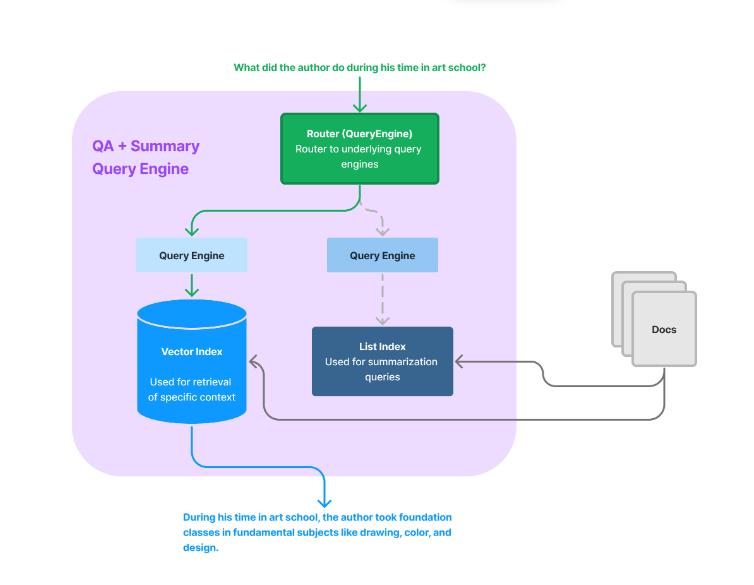


RAG no se trata solo de responder preguntas sobre hechos específicos, para los cuales está optimizada la similitud top-k. Puede haber una amplia gama de consultas que un usuario podría realizar. Las consultas que son manejadas *Naive RAG* incluyen aquellas que preguntan sobre hechos específicos, p. “Háblame de las iniciativas de D&I para esta empresa en 2023” o “Qué hizo el narrador durante su paso por Google”. Pero las consultas también pueden incluir resúmenes, p. "¿Puede darme una descripción general de alto nivel de este documento" o comparaciones? "¿Puede comparar/contrastar X e Y?". Todos estos casos de uso pueden requerir diferentes técnicas de recuperación.

LlamaIndex proporciona algunas abstracciones básicas para ayudar a realizar la recuperación de tareas específicas. Esto incluye un módulo de enrutador y un módulo de agente de datos, algunos módulos de motor de consulta avanzado y también  otros módulos que unen datos estructurados y no estructurados.

Se pueden utilizar estos módulos para realizar resúmenes y respuestas conjuntas a preguntas, o incluso combinar consultas estructuradas con consultas no estructuradas.

**Core Module Resources**

* Query engine (al inicio del notebook se ha visto algún ejemplo)
* Router
* Agents

**Detailed Guide Resources**

* Sub-Question Query Engine
* Joint QA-Summary
* Recursive Retriever Agents
* Router Query Engine
* OpenAI Agent Cookbook
* OpenAIAgent Query Planning

**Routing**

https://docs.llamaindex.ai/en/stable/module_guides/querying/router/#routers

La forma más sencilla de agentes de razonamiento. Dada la consulta del usuario y el conjunto de opciones, existe un conjunto de opciones de salida para dirigir la consulta de manera óptima.

Los *Routers* son módulos que aceptan una consulta de usuario y un conjunto de "opciones" (definidas por metadatos) y devuelven una o más opciones seleccionadas. Se pueden utilizar solos (como "módulos de selección") o como motor de consulta o recuperador (p. ej., además de otros motores de consulta/recuperadores).

Son módulos sencillos pero potentes que utilizan LLM para la toma de decisiones. Se pueden utilizar para los siguientes casos de uso:

- Seleccionar la fuente de datos adecuada entre una amplia gama de fuentes de datos. Por ejemplo, se podría dividir la documentación por años, ámbito de conocimiento o por organismo.
- Decidir si se debe realizar un resumen (p. ej., con un motor de consultas de índice de resumen) o una búsqueda semántica (p. ej., con un motor de consultas de índice de vectores)
- Decidir si "probar" un montón de opciones a la vez y combinar los resultados (utilizando capacidades de Routing* múltiple).

**Router Query Engine**

https://docs.llamaindex.ai/en/stable/examples/query_engine/RouterQueryEngine/


In [82]:
import nest_asyncio

nest_asyncio.apply()

from llama_index.core import SimpleDirectoryReader

# load documents
documents = SimpleDirectoryReader("data/paul_graham").load_data()

In [83]:
from llama_index.core import Settings

# initialize settings (set chunk size)
Settings.chunk_size = 1024
nodes = Settings.node_parser.get_nodes_from_documents(documents)

In [84]:
from llama_index.core import StorageContext

# initialize storage context (by default it's in-memory)
storage_context = StorageContext.from_defaults()
storage_context.docstore.add_documents(nodes)

In [85]:
from llama_index.core import SummaryIndex
from llama_index.core import VectorStoreIndex

summary_index = SummaryIndex(nodes, storage_context=storage_context)
vector_index = VectorStoreIndex(nodes, storage_context=storage_context)

In [86]:
list_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
vector_query_engine = vector_index.as_query_engine()

In [87]:
from llama_index.core.tools import QueryEngineTool


list_tool = QueryEngineTool.from_defaults(
    query_engine=list_query_engine,
    description=(
        "Useful for summarization questions related to Paul Graham eassy on"
        " What I Worked On."
    ),
)

vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description=(
        "Useful for retrieving specific context from Paul Graham essay on What"
        " I Worked On."
    ),
)

In [93]:
response = query_engine.query("What is the summary of the document?")
print(str(response))

The document provides a detailed account of an individual's journey from his early experiences with writing and programming to his exploration of artificial intelligence (AI) and eventual transition to pursuing art. It describes his fascination with computers, particularly microcomputers, his interest in the Lisp programming language, and his disillusionment with traditional AI approaches. The narrative then shifts to his pursuit of art, including applying to art schools and his experiences at RISD and the Accademia di Belli Arti in Florence. It also touches on his experiences working at Interleaf, his decision to move to New York City to pursue painting, and his involvement in founding Viaweb, an early e-commerce platform. The document further details his journey of creating a new Lisp language called Bel, inspired by John McCarthy's original Lisp, and reflects on his personal and professional endeavors, emphasizing the importance of following genuine interests and motives in one's pu

In [91]:
response = query_engine.query("What did Paul Graham do after RICS?")
print(str(response))

After RICS, Paul Graham started working on a new project where he recruited Dan Giffin and two undergrads to build an application builder. This project eventually led to the creation of a new company named Aspra, focusing on web applications. However, halfway through the summer, Paul Graham realized he did not want to run a company, especially a large one, and decided to shift his focus towards building a subset of the project as an open source initiative. This subset included working on a new dialect of Lisp, which he called Arc, in a house he bought in Cambridge.


In [95]:
# PydanticMultiSelector

from llama_index.core import SimpleKeywordTableIndex

keyword_index = SimpleKeywordTableIndex(nodes, storage_context=storage_context)

keyword_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description=(
        "Useful for retrieving specific context using keywords from Paul"
        " Graham essay on What I Worked On."
    ),
)

In [96]:
query_engine = RouterQueryEngine(
    selector=PydanticMultiSelector.from_defaults(),
    query_engine_tools=[
        list_tool,
        vector_tool,
        keyword_tool,
    ],
)

In [97]:
# This query could use either a keyword or vector query engine, so it will combine responses from both
response = query_engine.query(
    "What were noteable events and people from the authors time at Interleaf"
    " and YC?"
)
print(str(response))

The author's time at Y Combinator (YC) was marked by notable events and people. Some of the notable events included the Summer Founders Program where they received 225 applications, selected 8 groups to fund, and discovered successful founders like those from reddit, Twitch, and Aaron Swartz. The author also mentioned the growth and advantages of scaling startup funding through YC, highlighting the sense of community among alumni and the startups becoming each other's customers.

Additionally, during the author's time at YC, they worked on projects like Hacker News and YC's internal software in Arc. The author mentioned that working on Hacker News was a significant source of stress for them. As YC grew, the author gradually reduced their focus on other projects and realized that YC was taking up more of their attention.

Ultimately, the author decided to hand over YC to someone else after a personal event involving their mother's health. They approached Sam Altman to take over as presi

In [98]:
# [optional] look at selected results
print(str(response.metadata["selector_result"]))

selections=[SingleSelection(index=1, reason="This choice is relevant for retrieving specific context from the Paul Graham essay on What I Worked On, which can help in identifying notable events and people from the author's time at Interleaf and YC.")]


**Retriever Router Query Engine**

https://docs.llamaindex.ai/en/stable/examples/query_engine/RetrieverRouterQueryEngine/


In [108]:
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    StorageContext,
)
from llama_index.core import SummaryIndex

# load documents
documents = SimpleDirectoryReader("./data/paul_graham").load_data()

from llama_index.core import Settings

# initialize settings (set chunk size)
Settings.chunk_size = 1024
nodes = Settings.node_parser.get_nodes_from_documents(documents)

# initialize storage context (by default it's in-memory)
storage_context = StorageContext.from_defaults()
storage_context.docstore.add_documents(nodes)

In [101]:
summary_index = SummaryIndex(nodes, storage_context=storage_context)
vector_index = VectorStoreIndex(nodes, storage_context=storage_context)

In [102]:
from llama_index.core.tools import QueryEngineTool

list_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize", use_async=True
)
vector_query_engine = vector_index.as_query_engine(
    response_mode="tree_summarize", use_async=True
)

list_tool = QueryEngineTool.from_defaults(
    query_engine=list_query_engine,
    description="Useful for questions asking for a biography of the author.",
)
vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description=(
        "Useful for retrieving specific snippets from the author's life, like"
        " his time in college, his time in YC, or more."
    ),
)

In [103]:
from llama_index.core import VectorStoreIndex
from llama_index.core.objects import ObjectIndex

obj_index = ObjectIndex.from_objects(
    [list_tool, vector_tool],
    index_cls=VectorStoreIndex,
)

In [80]:
summary_index = SummaryIndex(nodes, storage_context=storage_context)
vector_index = VectorStoreIndex(nodes, storage_context=storage_context)

In [104]:
from llama_index.core.query_engine import ToolRetrieverRouterQueryEngine

query_engine = ToolRetrieverRouterQueryEngine(obj_index.as_retriever())

In [105]:
response = query_engine.query("What is a biography of the author's life?")

In [106]:
print(str(response))

The author's biography encompasses a diverse range of experiences, including writing essays, painting still lives, studying at the Accademia, working at Interleaf, and facing financial challenges while pursuing interests in art and software development. The journey involves exploring various creative endeavors, encountering difficulties in traditional education, and navigating the tech industry with a distinctive perspective on programming languages and work environments.


In [107]:
response

Response(response="The author's biography encompasses a diverse range of experiences, including writing essays, painting still lives, studying at the Accademia, working at Interleaf, and facing financial challenges while pursuing interests in art and software development. The journey involves exploring various creative endeavors, encountering difficulties in traditional education, and navigating the tech industry with a distinctive perspective on programming languages and work environments.", source_nodes=[NodeWithScore(node=TextNode(id_='6ff1fb59-815d-4a92-b357-5b1a6347c807', embedding=None, metadata={'file_path': '/content/data/paul_graham/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2024-05-05', 'last_modified_date': '2024-05-05'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', '

**Agents**

https://docs.llamaindex.ai/en/stable/module_guides/deploying/agents/

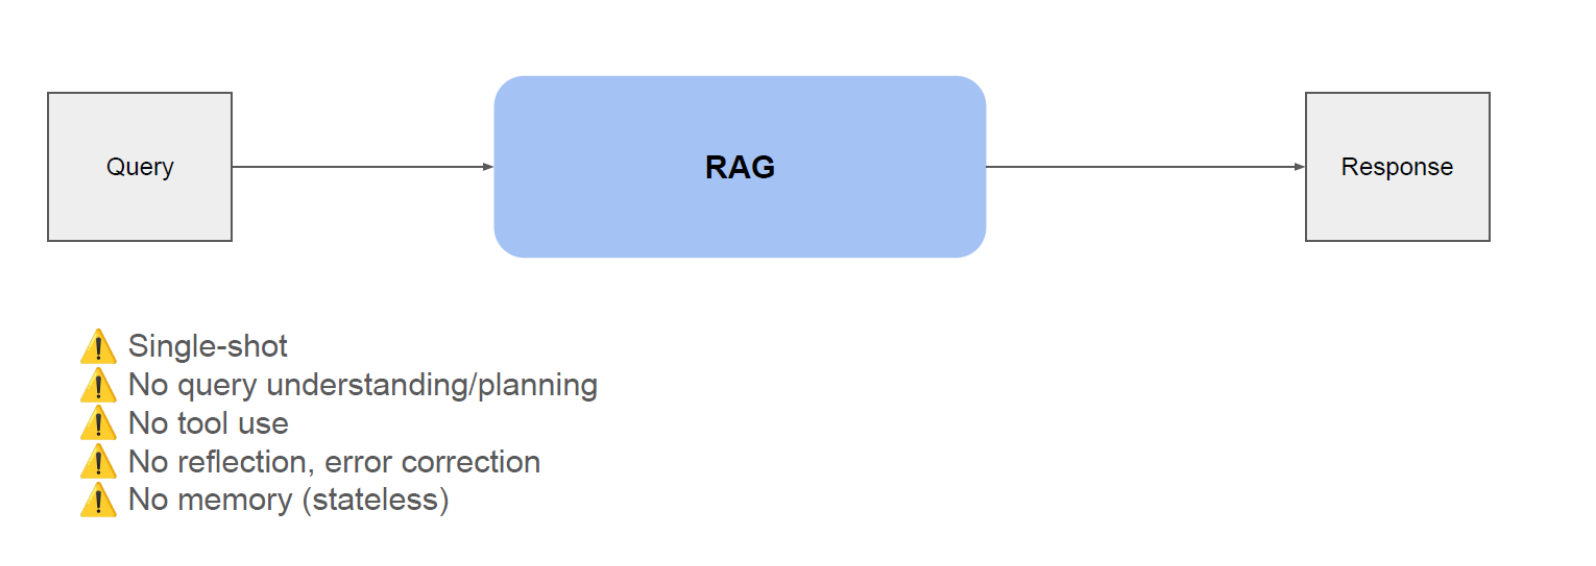

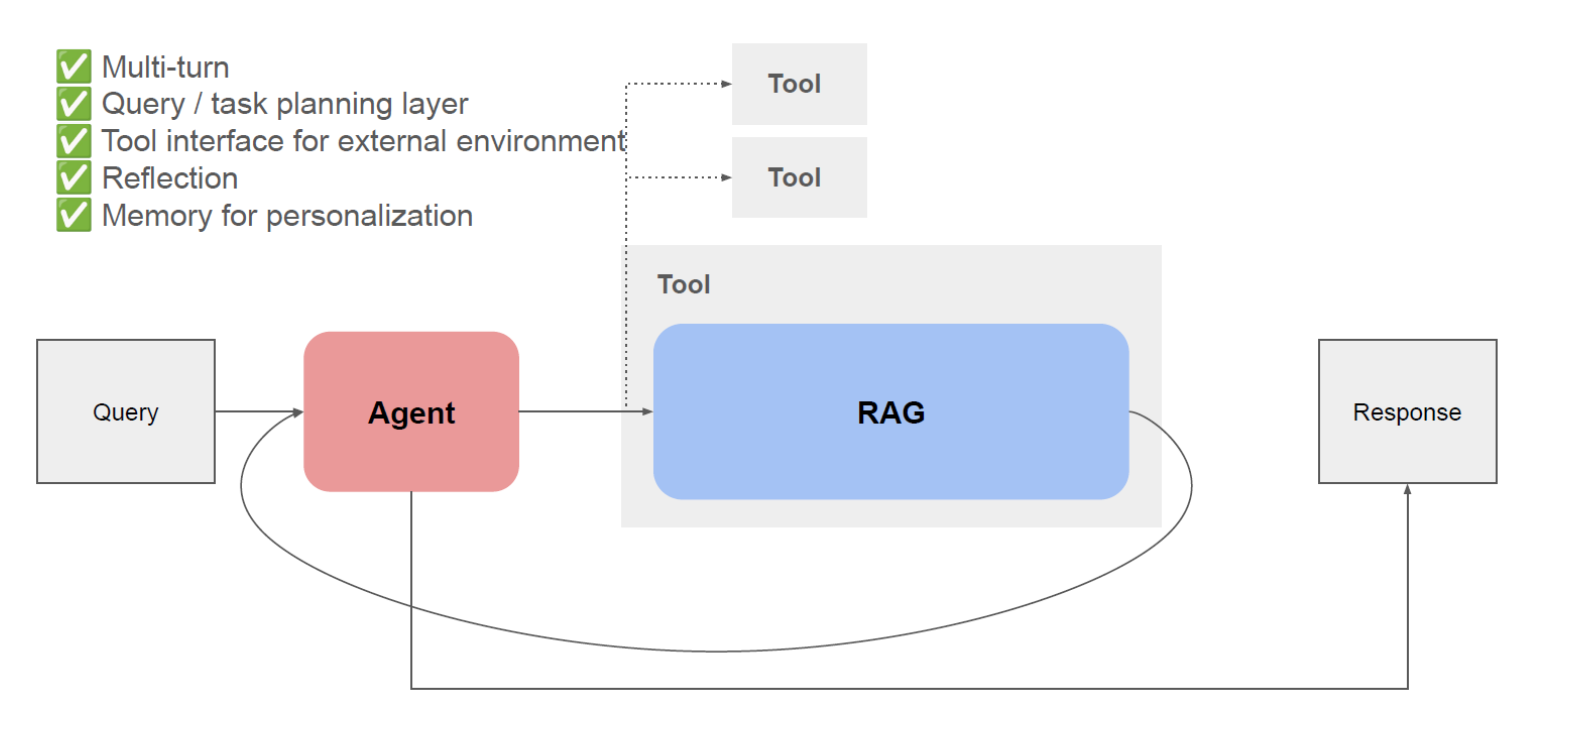

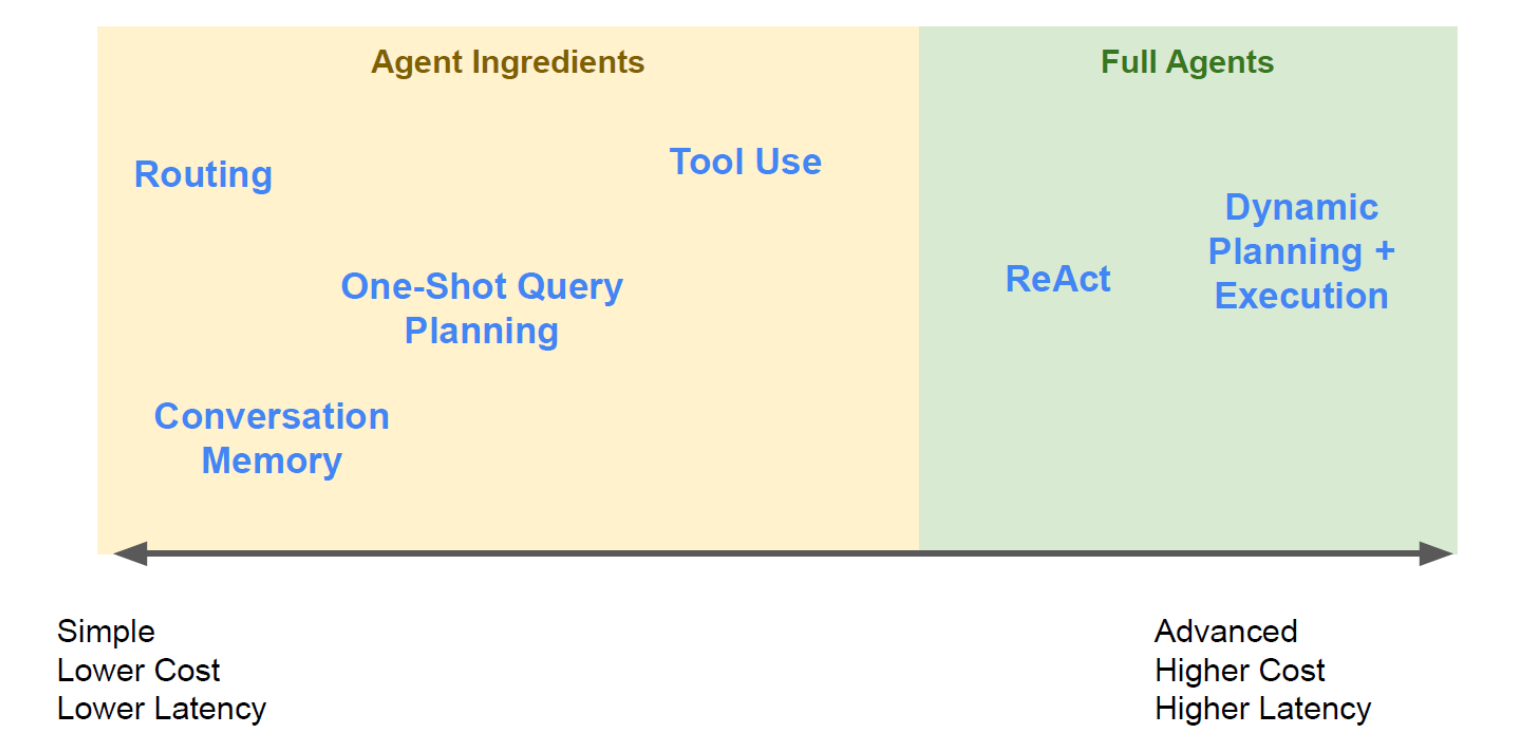

In [109]:
#ReAct Agent

from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    StorageContext,
)
from llama_index.core import SummaryIndex

# load documents
documents = SimpleDirectoryReader("./data/paul_graham").load_data()

from llama_index.core import Settings

# initialize settings (set chunk size)
Settings.chunk_size = 1024
nodes = Settings.node_parser.get_nodes_from_documents(documents)

# initialize storage context (by default it's in-memory)
storage_context = StorageContext.from_defaults()
storage_context.docstore.add_documents(nodes)

summary_index = SummaryIndex(nodes, storage_context=storage_context)
vector_index = VectorStoreIndex(nodes, storage_context=storage_context)

from llama_index.core.tools import QueryEngineTool

list_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize", use_async=True
)
vector_query_engine = vector_index.as_query_engine(
    response_mode="tree_summarize", use_async=True
)

list_tool = QueryEngineTool.from_defaults(
    query_engine=list_query_engine,
    description="Useful for questions asking for a biography of the author.",
)
vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description=(
        "Useful for retrieving specific snippets from the author's life, like"
        " his time in college, his time in YC, or more."
    ),
)

# Setup ReAct Agent

# Here we setup two ReAct agents: one powered by standard gpt-3.5-turbo, and the other powered by gpt-3.5-turbo-instruct.
# You can optionally specify context which will be added to the core ReAct system prompt

from llama_index.core.agent import ReActAgent
from llama_index.llms.openai import OpenAI

# context = """System Prompt"""

agent = ReActAgent.from_tools(
    [list_tool, vector_tool],
    verbose=True,
    #  context=context
)

response = agent.chat("What were noteable events and people from the authors time at Interleaf and YC?")
print(str(response))

Thought: The user is asking about notable events and people from the author's time at Interleaf and YC. I can use a tool to retrieve specific snippets from the author's life related to these experiences.
Action: query_engine_tool
Action Input: {'input': "notable events and people from the author's time at Interleaf and YC"}
Observation: The author's time at Interleaf was marked by his work on the Viaweb project, which eventually led to the creation of the first online store builder. At Y Combinator (YC), notable events included the launch of the Summer Founders Program, which attracted a significant number of applications from recent graduates and resulted in the funding of impressive startups like reddit, Twitch founders Justin Kan and Emmett Shear, Aaron Swartz, and Sam Altman. The batch model of funding startups twice a year and providing intensive support for three months was a key aspect of YC's approach.
Thought: I can answer the user's question without using any more tools.
Answ

In [110]:
response = agent.chat("What is a biography of the author's life?")
print(str(response))

Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: query_engine_tool
Action Input: {'input': 'Biography of the author'}
Observation: The author was a student at the Accademia where he painted still lives and also worked at a company called Interleaf. He later returned to the US and wanted to go back to RISD but was broke. He wrote essays and was involved in software development, particularly working with Lisp.
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: The author studied at the Accademia, where he painted still lives, and later worked at a company called Interleaf. Upon returning to the US, he aspired to go back to RISD but faced financial challenges. He wrote essays and was actively involved in software development, with a particular focus on working with Lisp.
The author studied at the Accademia, where he painted still lives, and later worked at a company called In

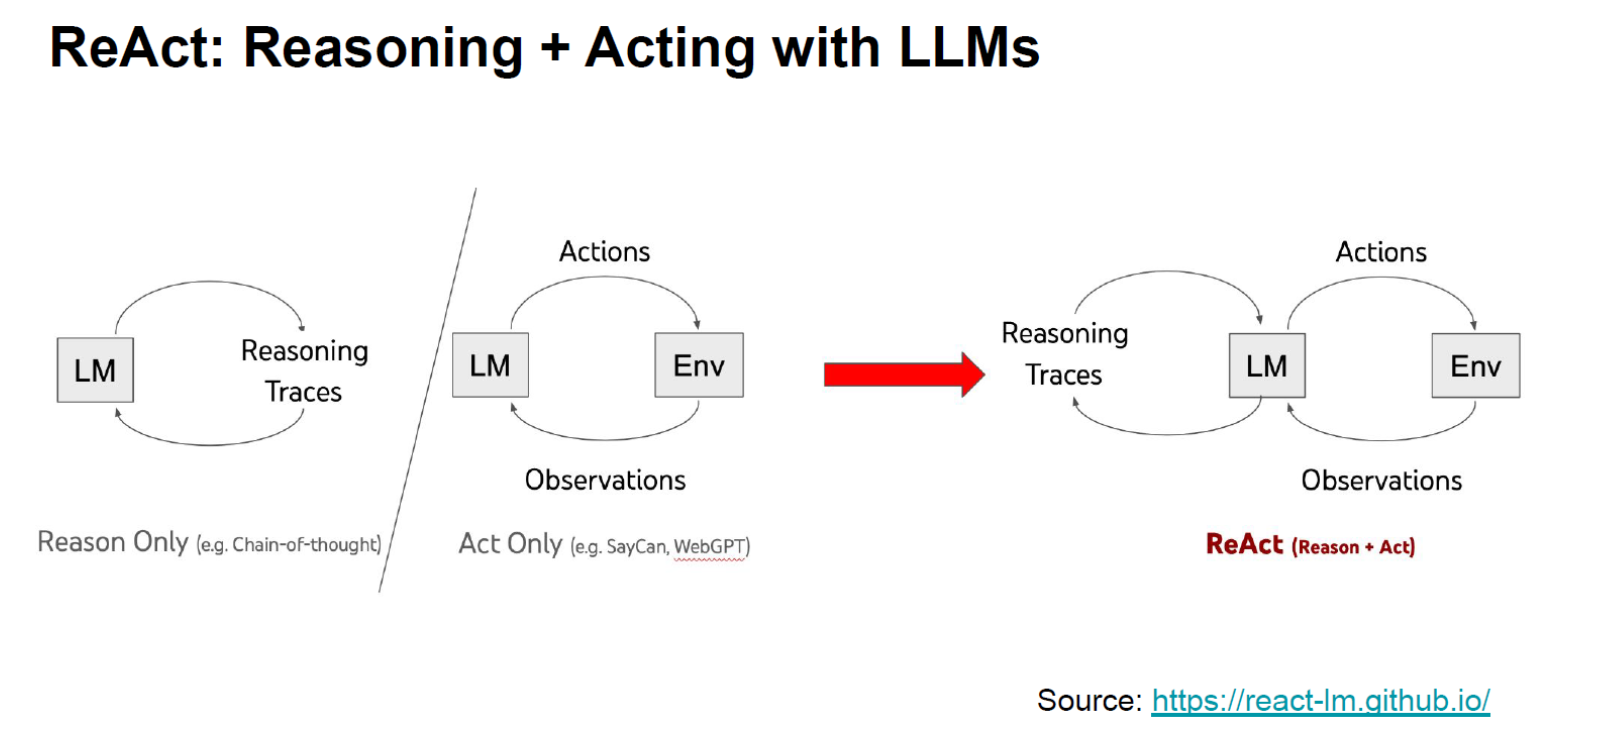

*CREDITS: El contenido está extraído de la presentación LlamaIndex Talk: "Beyond RAG: Building Advanced Context-Augmented LLM Applications de Jerry Liu, LlamaIndex co-founder/CEO" y de fuentes oficiales de la página web https://www.llamaindex.ai/*